In [1]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from visualization import papermode

papermode(plt, size=22)


In [2]:
def abbrange(letter:str, a:int, b:int)->Tuple[str]:
    return (f"{letter}{i:02}" for i in range(a,b))

In [3]:
d_abbrs = (*abbrange("D", 1, 7), "D09", "D11", "D12", "D13", "D14", "D16", *abbrange("D", 18, 23))
m_abbrs = abbrange("M", 1, 8)
r_abbrs = ("R02", "R03", "R07", "R08", "R09", "R10", "R12", "R14")
p_abbrs = abbrange("P", 1, 11)
s_abbrs = (*abbrange("S", 1, 11), "S21", "S22", "S23", "S28", "S29", "S30", "S31")
t_abbrs = ("TA", "TB", "TC")

abbrs = (
    *m_abbrs,
    *r_abbrs,
    *p_abbrs,
    *abbrange("D", 1, 3),
    # *d_abbrs,
    # *s_abbrs,
    # *t_abbrs,
)


In [4]:
import collections
all_terrains = {abbr:u.get_terrain(abbr) for abbr in abbrs}
for k, v in all_terrains.items():
    print(f"{k} : {v}")
collections.Counter(all_terrains.values())

M01 : asphalt
M02 : asphalt
M03 : asphalt
M04 : asphalt
M05 : gravel
M06 : gravel
M07 : gravel
R02 : snow
R03 : snow
R07 : snow
R08 : snow
R09 : snow
R10 : snow
R12 : snow
R14 : snow
P01 : vegetal
P02 : vegetal
P03 : vegetal
P04 : vegetal
P05 : vegetal
P06 : vegetal
P07 : asphalt
P08 : vegetal
P09 : vegetal
P10 : vegetal
D01 : sandy loam
D02 : sandy loam


Counter({'asphalt': 5, 'gravel': 3, 'snow': 8, 'vegetal': 9, 'sandy loam': 2})

In [5]:
colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}
terrains = sorted(set(u.get_terrain(a) for a in abbrs))
terr_cols = {terr: colors[terr] for terr in terrains}

# Simple labels
splabs = u.COLORS


def add_terrain_legend(
    mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure],
    highlighted: Optional[List[str]] = None,
    layout: str = "vertical",
):
    legend_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in terr_cols.items()]
    if highlighted is not None:
        legend_handles.extend([mpatches.Patch(color="xkcd:bright red", label=lab) for lab in highlighted])
    # mpl_elem.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0), loc="lower left")
    if layout.lower == "vertical":
        mpl_elem.legend(
            handles=legend_handles,
            bbox_to_anchor=(1, 0.5),
            loc="center left",
            title="Terrain",
        )
    else:
        mpl_elem.legend(
            handles=legend_handles,
            ncol=len(colors),
            bbox_to_anchor=(0.5, -0.03),
            loc="upper center",
            title="Terrain",
        )


In [6]:
figdir = u.get_figdir("thesis", subdir="modeling/distribution")

# Distribution

In [7]:
abbrs_dict = [{"abbr":a, "terrain":u.get_terrain(a)} for a in abbrs]
mu_df = pd.DataFrame(abbrs_dict)
model_values = u.model_subset_from_json(abbrs, pentzer2022.__MODEL_NAME__)
# mu_df["mu"] = mu_df.abbr.apply(lambda x: model_values[x]["coefficients"]["m_sym"]["last"])
m2009_dfs = {abbr: morales2009.open_model_df(abbr) for abbr in abbrs}
p2014_dfs = {abbr: pentzer2014pow.open_model_df(abbr) for abbr in abbrs}
p2022_dfs = {abbr: pentzer2022.open_model_df(abbr) for abbr in abbrs}
mu_df["mu_m2009"] = mu_df.abbr.apply(lambda x: m2009_dfs[x].m_sym.dropna().iloc[-int(len(m2009_dfs[x].index)/6):].to_numpy())
mu_df["mu_p2014"] = mu_df.abbr.apply(lambda x: p2014_dfs[x].m_sym.dropna().iloc[-int(len(p2014_dfs[x].index)/6):].to_numpy())
mu_df["mu_p2022"] = mu_df.abbr.apply(lambda x: p2022_dfs[x].m_sym.dropna().iloc[-int(len(p2022_dfs[x].index)/6):].to_numpy())
mu_df["G_m2009"] = mu_df.abbr.apply(lambda x: m2009_dfs[x].G_sym.dropna().iloc[-int(len(m2009_dfs[x].index)/6):].to_numpy())
mu_df["G_p2014"] = mu_df.abbr.apply(lambda x: p2014_dfs[x].G_sym.dropna().iloc[-int(len(p2014_dfs[x].index)/6):].to_numpy())
mu_df["G_p2022"] = mu_df.abbr.apply(lambda x: p2022_dfs[x].G_sym.dropna().iloc[-int(len(p2022_dfs[x].index)/6):].to_numpy())

In [8]:
terrains = [
    "gravel",
    "asphalt",
    "vegetal",
    "sandy loam",
    "snow",
]
y_data = {
    "m2009": [np.concatenate(mu_df[mu_df.terrain == terr].mu_m2009.values) for terr in terrains],
    "p2014": [np.concatenate(mu_df[mu_df.terrain == terr].mu_p2014.values) for terr in terrains],
    "p2022": [np.concatenate(mu_df[mu_df.terrain == terr].mu_p2022.values) for terr in terrains],
}
models = tuple(y_data.keys())


def mod_abbr_to_name(mod_abbr: str) -> str:
    models_names = {
        "m2009": "Simplex Optimization",
        "p2014": "RLS",
        "p2022": "RLS with slope",
    }
    return models_names[mod_abbr]


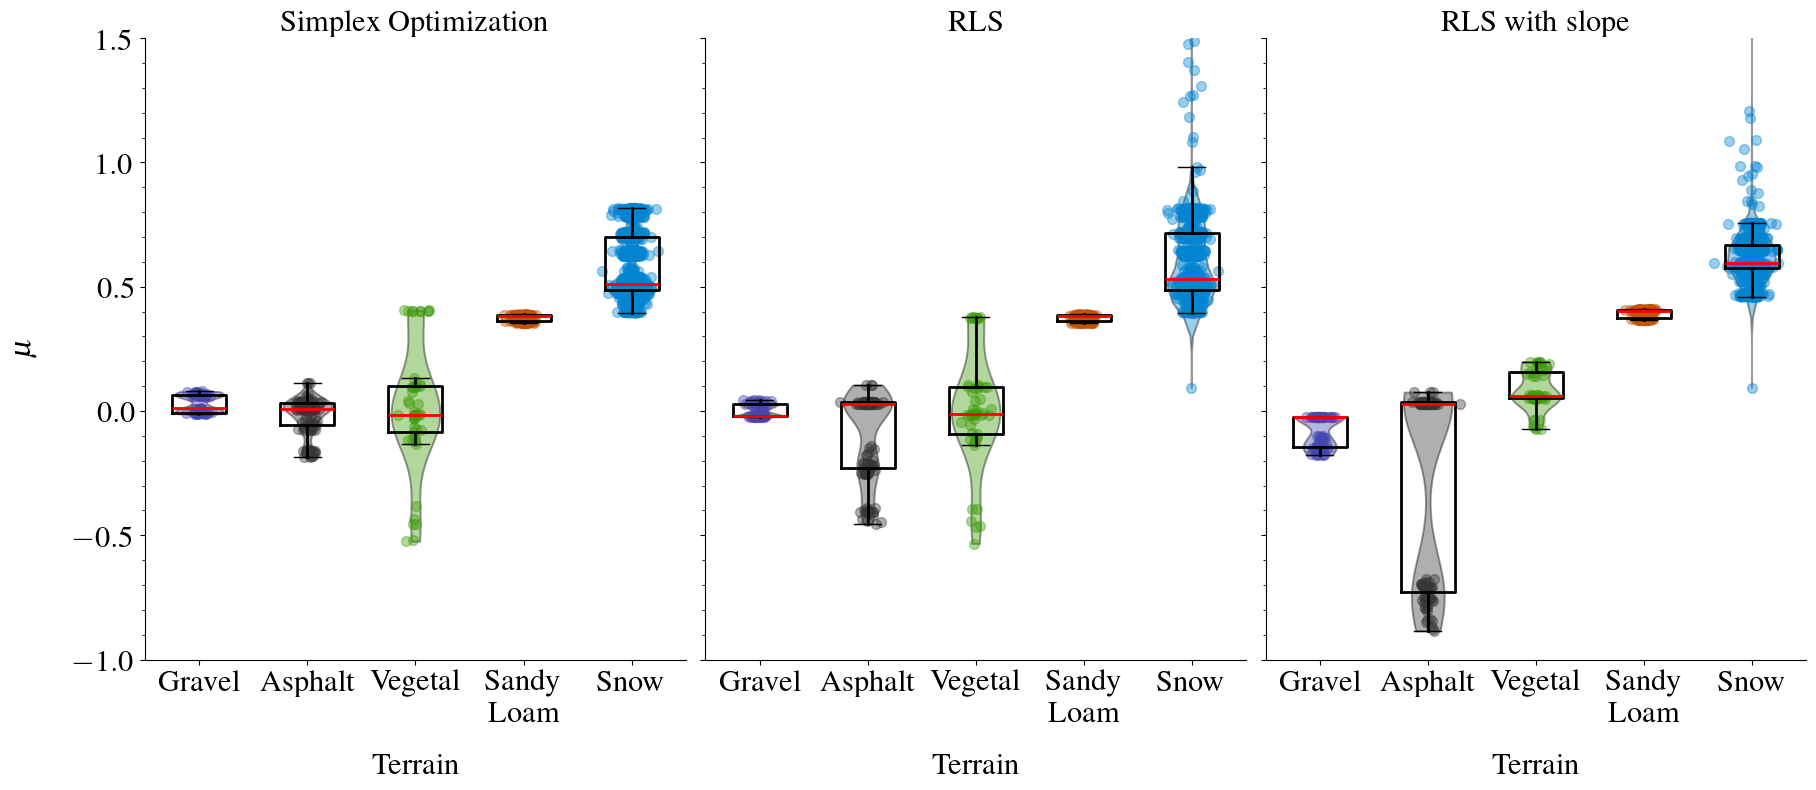

In [9]:
fig, subfigs = plt.subplots(sharey=True, ncols=3, figsize=(18,8))

for mod, ax in zip(models, subfigs.reshape(-1)):
    jitter = 0.04
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data[mod])]
    x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

    x_pos = [*range(len(y_data[mod]))]

    medianprops = dict(
        linewidth=2,
        color="r",
    )
    boxprops = dict(linewidth=2, color="k")

    violins = ax.violinplot(
        y_data[mod],
        positions=x_pos,
        widths=0.45,
        bw_method="silverman",
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )

    for pc, terr in zip(violins["bodies"], terrains):
        pc.set_facecolor(colors[terr])
        pc.set_edgecolor("k")
        pc.set_linewidth(1.4)
        pc.set_alpha(0.4)

    ax.boxplot(
        y_data[mod],
        positions=x_pos,
        showfliers=False,
        showcaps=True,  # Do not show the caps
        medianprops=medianprops,
        whiskerprops=boxprops,
        boxprops=boxprops,
    )

    for x, y, terr in zip(x_jittered, y_data[mod], terrains):
        ax.scatter(x, y, s=50, color=colors[terr], alpha=0.4)

    xlabels = [terr.title() for terr in terrains]
    xlabels[3] = "\n".join(xlabels[3].split(" "))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xlabels)
    # ax.set_xticklabels(xlabels, rotation=45, ha="center")

    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")

    ax.set_title(mod_abbr_to_name(mod))

    ax.set_xlabel("Terrain")
    ax.xaxis.set_label_coords(0.5, -0.15)


subfigs[0].set_ylim(bottom=-1, top=1.5)
subfigs[0].set_ylabel("$\mu$")
subfigs[0].yaxis.set_label_coords(-0.2, 0.5)
subfigs[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"mbplot.{ext}", bbox_inches="tight")


In [10]:
" ".join(abbrs)

'M01 M02 M03 M04 M05 M06 M07 R02 R03 R07 R08 R09 R10 R12 R14 P01 P02 P03 P04 P05 P06 P07 P08 P09 P10 D01 D02'

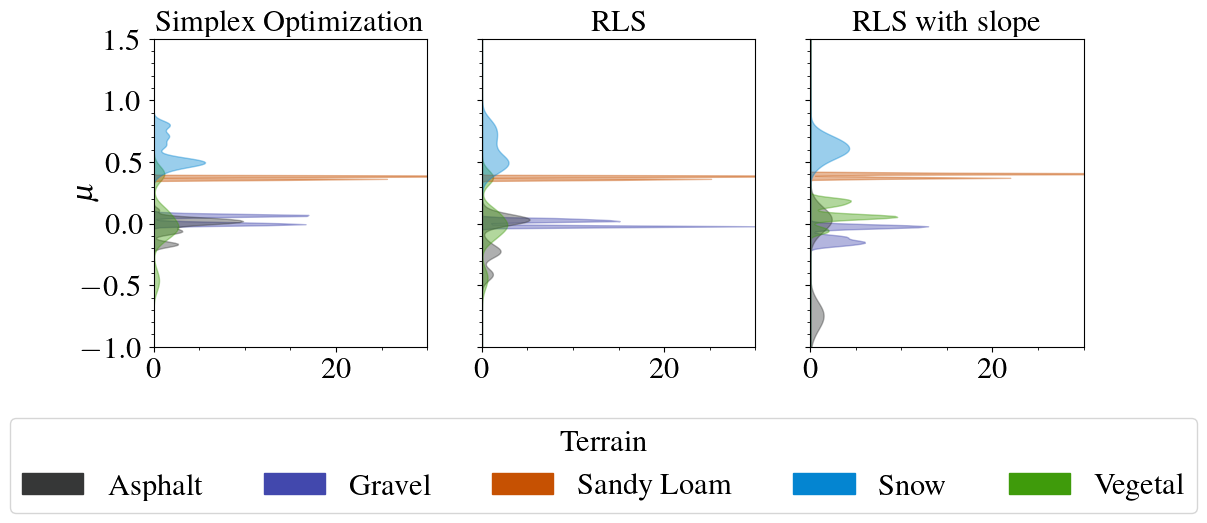

In [11]:
fig, subfigs = plt.subplots(figsize=(12,4), ncols=3, sharey=True)

subfigs[0].set_ylim(bottom=-1, top=1.5)
subfigs[0].set_ylabel("$\mu$")
subfigs[0].yaxis.set_label_coords(-0.2, 0.5)
subfigs[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

for mod, ax in zip(models, subfigs.reshape(-1)):
    ax.set_title(mod_abbr_to_name(mod))
    ax.set_xlim(left=0, right=30)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ys = np.linspace(*subfigs[0].get_ylim(), num=300)

    for terr, terr_mu in zip(terrains, y_data[mod]):
        terr_col = colors[terr]

        density = st.gaussian_kde(terr_mu)
        density.covariance_factor = lambda: .25
        density._compute_covariance()

        ax.fill_betweenx(ys, density(ys), color=terr_col, alpha=0.4)

add_terrain_legend(fig, layout="horizontal")
# fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"mdist.{ext}", bbox_inches="tight")

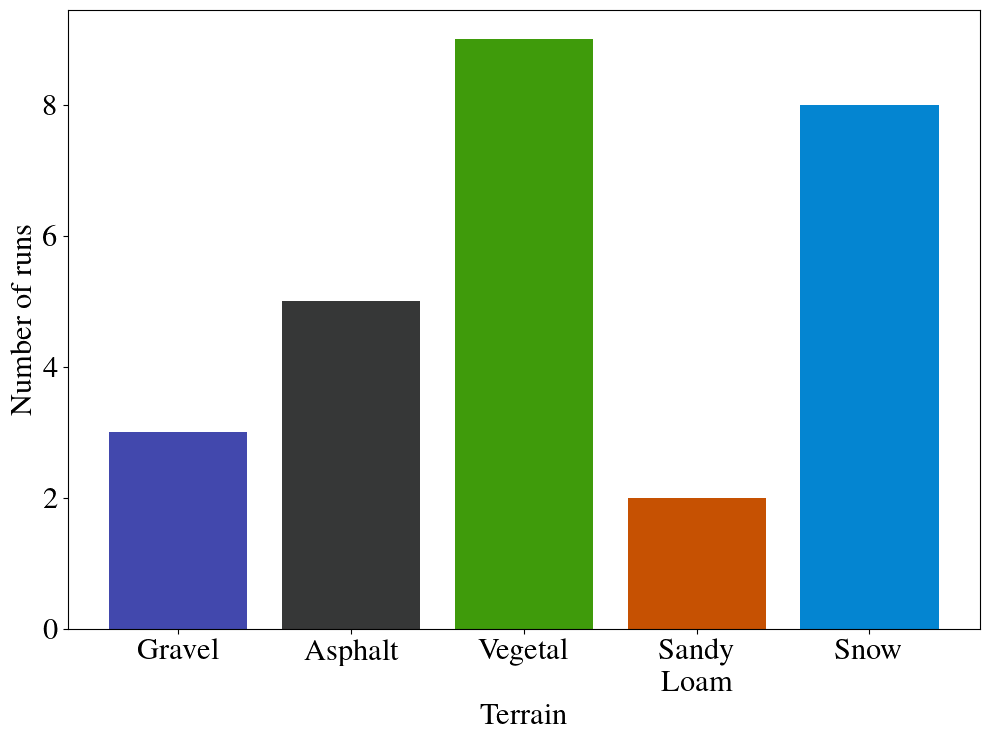

In [12]:
mu_df
fig, ax = plt.subplots(figsize=(10,7.5))

bar_terrains = terrains.copy()
bar_labels = [terr.title() for terr in bar_terrains]
bar_labels[3] = "\n".join(bar_labels[3].split(" "))
bar_colors = [terr_cols[terr] for terr in bar_terrains]
counts = [len(mu_df[mu_df.terrain == terr]) for terr in bar_terrains]

ax.bar(bar_labels, counts, color=bar_colors)
ax.set_ylabel("Number of runs")
ax.set_xlabel("Terrain")
fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"nruns.{ext}", bbox_inches="tight")


In [1]:
mu_df.head()

NameError: name 'mu_df' is not defined

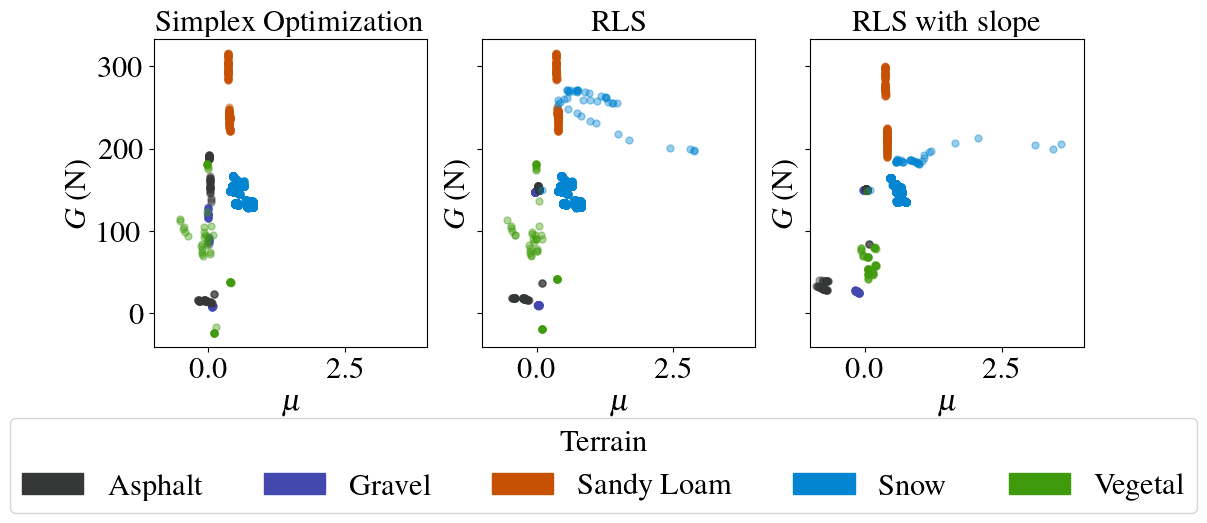

In [20]:
fig, subfigs = plt.subplots(figsize=(12,4), ncols=3, sharey=True)

mG_data = {
    "m_m2009": [np.concatenate(mu_df[mu_df.terrain == terr].mu_m2009.values) for terr in terrains],
    "m_p2014": [np.concatenate(mu_df[mu_df.terrain == terr].mu_p2014.values) for terr in terrains],
    "m_p2022": [np.concatenate(mu_df[mu_df.terrain == terr].mu_p2022.values) for terr in terrains],
    "G_m2009": [np.concatenate(mu_df[mu_df.terrain == terr].G_m2009.values) for terr in terrains],
    "G_p2014": [np.concatenate(mu_df[mu_df.terrain == terr].G_p2014.values) for terr in terrains],
    "G_p2022": [np.concatenate(mu_df[mu_df.terrain == terr].G_p2022.values) for terr in terrains],
}
models = ("m2009", "p2014", "p2022")
# subfigs[0].set_ylim(bottom=-1, top=1.5)
# subfigs[0].set_ylabel("$\mu$")
# subfigs[0].yaxis.set_label_coords(-0.2, 0.5)
# subfigs[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

for mod, ax in zip(models, subfigs.reshape(-1)):
    ax.set_title(mod_abbr_to_name(mod))
    # ax.set_xlim(left=0, right=30)
    # ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    mod_m = mG_data[f"m_{mod}"]
    mod_G = mG_data[f"G_{mod}"]

    for terr, terr_mu, terr_G in zip(terrains, mod_m, mod_G):
        terr_col = colors[terr]
        ax.plot(terr_mu, terr_G, marker="o", linestyle="", markersize=5, label=terr, color=u.COLORS[terr], alpha=0.4)

    ax.set_xlim(left=-1, right=4)

    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$G$ (N)")

add_terrain_legend(fig, layout="horizontal")
# fig.tight_layout()